# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import tensorflow as tf

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Pickled data loaded!')

Pickled data loaded!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

The pickled data contains resized versions (32 by 32) of the images.

### Basic Summary of the Dataset

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# Number of classes/labels there in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_validation)
print("Number of testing examples: ", n_test)
print("Image data shape: ", image_shape)
print("Number of classes: ", n_classes)

Number of training examples:  34799
Number of validation examples:  4410
Number of testing examples:  12630
Image data shape:  (32, 32, 3)
Number of classes:  43


### Visualization of the dataset

Visualization of the German Traffic Signs Dataset is provided here by plotting the following:
- a random image from the data set
- a histogram showing the distribution of different labels in the dataset


28


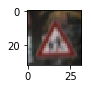

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])


Training dataset:


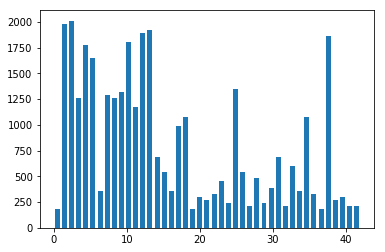

Validation dataset:


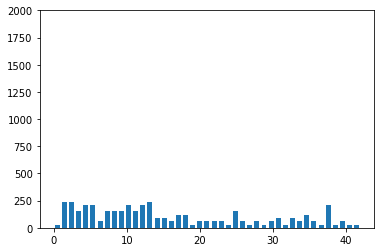

Test dataset:


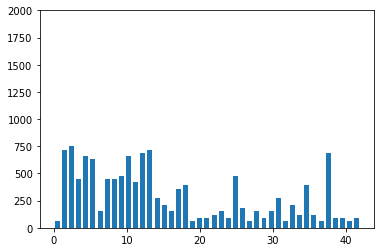

In [4]:
# Plot label frequency in training, validation and test dataset
hist_train, bins = np.histogram(y_train, bins=n_classes)
hist_valid, bins = np.histogram(y_valid, bins=n_classes)
hist_test, bins = np.histogram(y_test, bins=n_classes)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, hist_train, align='center', width=width)
print("Training dataset:")
plt.show()

plt.bar(center, hist_valid, align='center', width=width)
print("Validation dataset:")
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()

plt.bar(center, hist_test, align='center', width=width)
print("Test dataset:")
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()

----

## Step 2: Design and Test a Model Architecture

In this step, I designed and implemented a deep learning model that learns to recognize traffic signs. I later trained and tested my model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The minimum validation set accuracy required for the project was 0.93, which I acheived using the LeNet-5 architecture and modifying it with based on the recommended article by Yann Lecun ([published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)).

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others)
- Generating fake data (data augmentation)

In my solution, I played with the neural network architecture and the preprocessing techniques. In the end I implemented an architecture similar to that in the article referenced above and I used normalization and grayscaling for preprocessing the data.


### Pre-process the Data Set (normalization and grayscale)

Images are grayscaled simply by averaging the RGB values. Next the images are normalized using `(pixel - 128)/ 128` so that the data has a mean close to zero and equal variance.

In [5]:
def grayscale(rgb_images):
    return np.sum(rgb_images/3, axis=3, keepdims=True)

def normalize(images):
    return (images - 128.0) / 128.0

X_train_gray = grayscale(X_train)
X_valid_gray = grayscale(X_valid)
X_test_gray = grayscale(X_test)

X_train_normalized = normalize(X_train_gray)
X_valid_normalized = normalize(X_valid_gray)
X_test_normalized = normalize(X_test_gray)

print("Image pre-processing done!")
print("Image shape:", X_train_normalized[0].shape)
print("Mean value of first image:", np.mean(X_train_normalized[0]))
print("Variance of first image:", np.var(X_train_normalized[0]))

Image pre-processing done!
Image shape: (32, 32, 1)
Mean value of first image: -0.657173156738
Variance of first image: 0.0356915945433


### Model Architecture

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1
    
     # Layer 1: Convolutional, Input = 32x32x1, Output = 28x28x6
    conv1_W = tf.Variable(tf.random_normal((5, 5, 1, 6), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(6))                      
    conv1 = tf.add(tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID'), conv1_b, "conv1")
    
    # Activation
    conv1 = tf.nn.relu(conv1)
                           
    # Pooling: Input = 28x28x6, Output = 14x14x6
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name="pool1")

    # Layer 2: Convolutional, Output = 10x10x16
    conv2_W = tf.Variable(tf.random_normal((5, 5, 6, 16), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))                      
    conv2 = tf.add(tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID'), conv2_b, "conv2")
    
    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling: Input = 10x10x16, Output = 5x5x16
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name="pool2")

    # Layer 3: Convolutional, Output = 1x1x400
    conv3_W = tf.Variable(tf.random_normal((5, 5, 16, 400), mu, sigma))
    conv3_b = tf.Variable(tf.zeros(400))                      
    conv3 = tf.add(tf.nn.conv2d(pool2, conv3_W, strides=[1, 1, 1, 1], padding='VALID'), conv3_b, "conv3")
    
    # Activation
    conv3 = tf.nn.relu(conv3)
    
    # Flatten: Input = 10x10x16, Output = 1600
    flattened_conv2 = flatten(conv2)
    
    # Flatten: Input = 1x1x400, Output = 400
    flattened_conv3 = flatten(conv3)
    
    # Concatenate flattened_conv2 and flattened_conv3: Input = 1600 + 400, Output = 2000
    concat = tf.concat(values=[flattened_conv2, flattened_conv3], axis=1)

    # Dropout layer
    dr1 = tf.nn.dropout(concat, keep_prob)

    # Layer 5: Fully Connected, Input = 2000, Output = 43
    fc3_W = tf.Variable(tf.random_normal((2000, 43), mu, sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(dr1, fc3_W), fc3_b)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
Validation Accuracy = 0.796
Training Accuracy = 0.881
EPOCH 2 ...
Validation Accuracy = 0.873
Training Accuracy = 0.951
EPOCH 3 ...
Validation Accuracy = 0.896
Training Accuracy = 0.970
EPOCH 4 ...
Validation Accuracy = 0.910
Training Accuracy = 0.981
EPOCH 5 ...
Validation Accuracy = 0.918
Training Accuracy = 0.987
EPOCH 6 ...
Validation Accuracy = 0.918
Training Accuracy = 0.989
EPOCH 7 ...
Validation Accuracy = 0.932
Training Accuracy = 0.992
EPOCH 8 ...
Validation Accuracy = 0.935
Training Accuracy = 0.994
EPOCH 9 ...
Validation Accuracy = 0.941
Training Accuracy = 0.996
EPOCH 10 ...
Validation Accuracy = 0.933
Training Accuracy = 0.996
EPOCH 11 ...
Validation Accuracy = 0.935
Training Accuracy = 0.997
EPOCH 12 ...
Validation Accuracy = 0.929
Training Accuracy = 0.997
EPOCH 13 ...
Validation Accuracy = 0.938
Training Accuracy = 0.998
EPOCH 14 ...
Validation Accuracy = 0.928
Training Accuracy = 0.998
EPOCH 15 ...
Validation Accuracy = 0.944
Training Accuracy

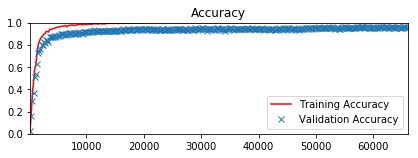

Validation accuracy at 0.9605442174437906
Training accuracy at 0.9999137906261674


In [7]:
from sklearn.utils import shuffle

# Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

# Training pipeline
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Measurements used for graphing loss and accuracy
log_batch_step = 200
batches = []
train_acc_batch = []
valid_acc_batch = []

# Training the model
EPOCHS = 30
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            #print("running session...")
            
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
            if not offset % log_batch_step:
                
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                
                training_accuracy = evaluate(X_train_normalized, y_train)
                train_acc_batch.append(training_accuracy)
                validation_accuracy = evaluate(X_valid_normalized, y_valid)
                valid_acc_batch.append(validation_accuracy)
        
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        training_accuracy = evaluate(X_train_normalized, y_train)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))

    saver.save(sess, './lenet')
    print("Model saved")
    
# Plot accuracy
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()
print('Validation accuracy at {}'.format(validation_accuracy))
print('Training accuracy at {}'.format(training_accuracy))

In [8]:
# Test the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.937


---

## Step 3: Testing the Model on New Images

To give myself more insight into how my model is working, I downloaded five pictures of German traffic signs from the web and used my model to predict the traffic sign type.

### Load and Output the Images

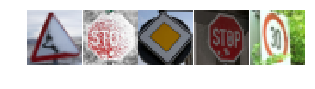

In [9]:
import glob
import cv2

fig, axs = plt.subplots(1,5, figsize=(5, 1))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./downloaded_images/*.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)
    
my_images = np.asarray(my_images)

my_images_gray = grayscale(my_images)
my_images_normalized = normalize(my_images_gray)

### Predict the Sign Type for Each Image & Analyze Performance

In [10]:
my_labels = [23, 14, 12, 14, 1]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))


INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, I printed out the model's softmax probabilities to show the **certainty** of the model's predictions using [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k).

`tf.nn.top_k` returns the values and indices (class ids) of the top k predictions. So if k=5, for each sign, it'll return the 5 largest probabilities (out of a possible 43) and the correspoding class ids.

INFO:tensorflow:Restoring parameters from ./lenet


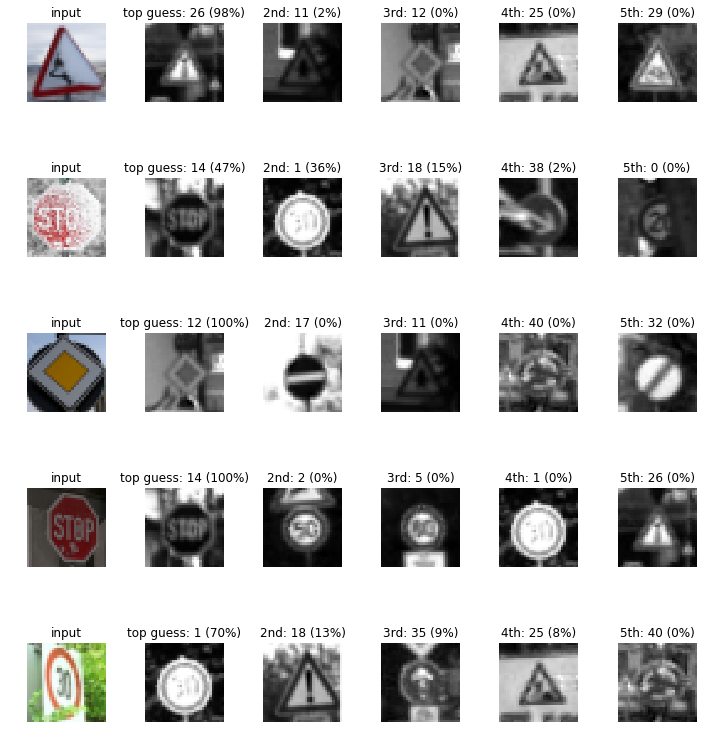

In [11]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})

    fig, axs = plt.subplots(len(my_images), 6, figsize=(12, 14))
    fig.subplots_adjust(hspace = .1, wspace=0.5)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[6*i].axis('off')
        axs[6*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[6*i].set_title('input')
        
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[6*i+1].axis('off')
        axs[6*i+1].imshow(X_valid_normalized[index1].squeeze(), cmap='gray')
        axs[6*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[6*i+2].axis('off')
        axs[6*i+2].imshow(X_valid_normalized[index2].squeeze(), cmap='gray')
        axs[6*i+2].set_title('2nd: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[6*i+3].axis('off')
        axs[6*i+3].imshow(X_valid_normalized[index3].squeeze(), cmap='gray')
        axs[6*i+3].set_title('3rd: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))
        
        guess4 = my_top_k[1][i][3]
        index4 = np.argwhere(y_valid == guess4)[0]
        axs[6*i+4].axis('off')
        axs[6*i+4].imshow(X_valid_normalized[index4].squeeze(), cmap='gray')
        axs[6*i+4].set_title('4th: {} ({:.0f}%)'.format(guess4, 100*my_top_k[0][i][3]))
        
        guess5 = my_top_k[1][i][4]
        index5 = np.argwhere(y_valid == guess5)[0]
        axs[6*i+5].axis('off')
        axs[6*i+5].imshow(X_valid_normalized[index5].squeeze(), cmap='gray')
        axs[6*i+5].set_title('5th: {} ({:.0f}%)'.format(guess5, 100*my_top_k[0][i][4]))
